# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [39]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit. But remember that it can take a long time to run, so give yourself enough time.** 

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [40]:
import random
from datetime import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit

import seaborn as sns
import scipy.stats as st

%matplotlib inline

print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

Using PyMC3 version: 3.11.4
Using ArviZ version: 0.11.4


In [41]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)
    

<a id="contents"></a>

## Notebook Contents

- [**Part 1: Rejection sampling and the weighted bootstrap**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**Part 2: Bayesian Logistic Regression and Varying-Intercepts Model**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


- [**Part 3: Varying-Coefficients Model and Model Selection**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions)
  - [Solutions](#part3solutions)


## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1,934 Bangladeshi women.

There are four attributes for each woman, along with a label `contraceptive_use` indicating if she uses contraceptives. The attributes include:

* `district`: identifying code for the district the woman lives in
* `urban`: type of region of residence
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 1:  Rejection sampling and the weighted bootstrap

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview 

[Return to contents](#contents)

For the first part of the problem, we will only work with the label `contraceptive_use` and ignore all the attributes.  Let $Y_i$ be 1 if woman $i$ uses contraceptives, and 0 otherwise.  Assume a Bernoulli model for the data:

$$Y_{i} \sim \text{Bernoulli}(\theta)$$

where $i=1,\ldots,N$, with $N$ being the number of observations in the training data set, and $\theta$ is the unknown probability a woman uses contraception.  We will assume the following prior distribution on $\theta$:

$$\theta \sim \text{Normal}(0.5, 0.5^2)$$

subject to $0 \leq \theta \leq 1$.  This is sometimes called a truncated normal distribution.  A value from this distribution can be randomly drawn by simulating a value from $\text{Normal}(0.5, 0.5^2)$ and then keeping it if the value is between 0 and 1, and trying again if it is outside this range.  In fact, this is a form of rejection sampling.  The density for the truncated normal distribution is

$$p(\theta) = c\times\frac{1}{\sqrt{2\pi (0.5)^2}} \: \exp\left(\frac{-1}{2(0.5)^2}(\theta-0.5)^2\right) \; \text{for} \; 0\leq \theta \leq 1 \; \text{, and} \; 0 \; \text{otherwise,}$$

where $c$ is a normalizing constant that does not depend on $\theta$.

<a id="part1questions"></a>

### <div class='exercise'>Part 1: Questions</div> 

[Return to contents](#contents)

**1.1** Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

**1.2** Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**

**1.3** Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


<a id="part1solutions"></a>

## Part 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**  Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.



</div>

Assuming that our data points are independently drawn from the same distribution, the likelihood function is simply the product of the individual distributions, which are generated from the Bernoulli with probability $\theta$:

$$L(\theta | y_1,\ldots,y_n) = p(y_1|\theta)*p(y_2|\theta)*p(y_3|\theta)*\ldots*p(y_n|\theta)$$

$$ = {\displaystyle \prod_{i=1}^{n} p(y_i|\theta)} $$

$$ = {\displaystyle \prod_{i=1}^{n} \theta^{y_i}*(1-\theta)^{(1-y_i)}} $$

$$ = \theta^{\sum_{i=1}^ny_i}*(1-\theta)^{1-\sum_{i=1}^ny_i}$$

$$\implies \text{log}(L(\theta | y_1,\ldots,y_n)) = \mathcal{L}(\theta | y_1,\ldots,y_n) = \sum_{i=1}^ny_i\text{log}\theta + (1-\sum_{i=1}^ny_i)\text{log}(1-\theta)$$

Since log is monotonically increasing, the log-likelihood will be maximized at the exact point at which the likelihood would be maximized. So, we maximize the log-likelihood by finding the point at which the deriviative with respect to $\theta$ is equal to 0:

$$\frac{\delta}{\delta\theta}[\mathcal{L}(\theta | y_1,\ldots,y_n)] = \frac{\delta}{\delta\theta}[\sum_{i=1}^ny_i\text{log}\theta + (1-\sum_{i=1}^ny_i)\text{log}(1-\theta)] = 0$$

$$\implies \frac{1}{\theta} * \sum_{i=1}^ny_i - \frac{1}{1-\theta} * (1-\sum_{i=1}^ny_i) = 0$$

$$\implies \frac{1}{\theta} * \sum_{i=1}^ny_i = \frac{1}{1-\theta} * (1-\sum_{i=1}^ny_i)$$

$$\implies (1-\theta)* \sum_{i=1}^ny_i = \theta * (1-\sum_{i=1}^ny_i)$$

$$\implies \theta = \frac{1}{n} * \sum_{i=1}^ny_i$$

so the value of $\theta$ which maximizes the log-likelihood function is simply the sample mean of our $y$ values.




In [42]:
df_train = pd.read_csv('data/dataset_2_train.csv')
df_test = pd.read_csv('data/dataset_2_test.csv')

In [43]:
y_train = df_train['contraceptive_use']
y_test = df_test['contraceptive_use']

x_train = df_train.drop(columns = ['contraceptive_use'])
x_test = df_test.drop(columns = ['contraceptive_use'])

In [44]:
mle_train = y_train.mean()
print(f'The maximum likelihood estimation, MLE, of the Bernoulli parameter for this dataset is {mle_train}')

The maximum likelihood estimation, MLE, of the Bernoulli parameter for this dataset is 0.38986556359875907


In [45]:
# mle_test = y_test.mean()
# mle_test

<div class='exercise-r'>

**1.2**  Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**



</div>

In [46]:
def likelihood(y, theta):
    return np.prod((theta**y)*(1- theta)**(1-y))

# your code here
def rejection_sampling(maxiter=10000,sampsize=1000):
    samples = []
    sampcount = 0  # counter for accepted samples
    maxcount = 0   # counter for proposal simulation
    # sampcount/maxcount at any point in the iteration is the acceptance rate

    while (sampcount < sampsize and maxcount < maxiter):
        theta = np.random.normal(0.5, 0.5**2) 
        u = np.random.uniform(0, 1) #way to encode true and false
        maxcount += 1

        if 0<= theta <=1:

            if u <= (likelihood(y_train,theta ) /likelihood(y_train,mle_train )): 

                samples.append(theta)
                sampcount += 1
    
    print('Rejection rate is',100*(1-sampcount/maxcount))
    if maxcount == maxiter: print('Maximum iterations achieved')
    return np.array(samples)



In [47]:
s = rejection_sampling(maxiter=10000,sampsize=10000)


Rejection rate is 94.44
Maximum iterations achieved


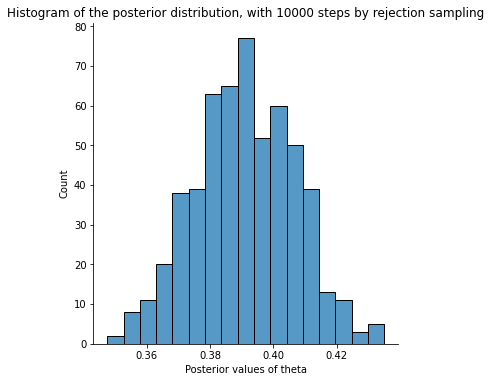

In [48]:
sns.displot(s)
plt.title('Histogram of the posterior distribution, with 10000 steps by rejection sampling')
plt.xlabel('Posterior values of theta')
plt.show()

In [49]:
s = pd.DataFrame(s)
s.columns = ['posterior_distribuition']
print(s.describe())
print()
print(f'The maximum likelihood estimate, MLE, of the Bernoulli parameter for this feature is {mle_train}')

CI_95 = np.percentile(s, [2.5, 97.5])
mode = st.mode(s)
print(f'The posterior credible interval is {CI_95}')
print(f'The posterior mode is {mode[0]}')


       posterior_distribuition
count               556.000000
mean                  0.391011
std                   0.015768
min                   0.347518
25%                   0.380081
50%                   0.390850
75%                   0.402460
max                   0.435064

The maximum likelihood estimate, MLE, of the Bernoulli parameter for this feature is 0.38986556359875907
The posterior credible interval is [0.36013623 0.4207054 ]
The posterior mode is [[0.34751844]]


**Intepretation:**

We completed a rejection sampling exercise (with a fairly high rejection rate of 94.0%) which yielded a posterior distribution that looks similar to a normal distribution (which was our prior). 

However, the mean of the distribution has been shifted by the new data which we used to update our prior. Using our new data, we have a 95% credible interval of (0.36, 0.42), which is fairly narrow. 

It is reasonable that this interval would be narrow and would encompass our sample mean – with nearly 1000 observations for contraception_use it is unlikely that the true theta would be very far from the sample mean (as we have shown).

<div class='exercise-r'>

**1.3**  Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


</div>

In [50]:
from sklearn import preprocessing

def weighted_bootstrap(iterations=1000,size=100):
    w = []
    y_ = []
    
    for i in range(iterations):
        theta = np.random.normal(0.5, 0.5**2)
        if 0<=theta<=1:
            y_.append(theta)
            wz = likelihood(y_train, theta) 
            w.append(wz)
    
    w_ = [float(i)/sum(w) for i in w] #normalizing the distribuition w
    v = random.choices(y_,weights=w_,k=size) 
    return np.array(v)

In [51]:
wb = weighted_bootstrap(iterations=10000,size=1000)

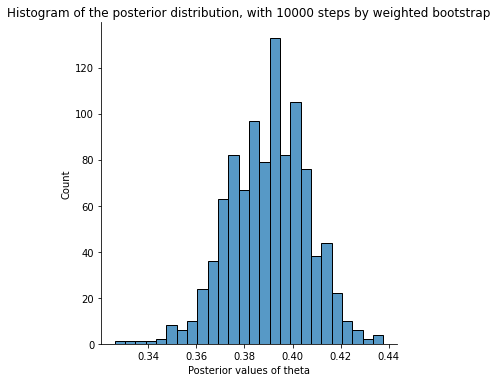

In [52]:
sns.displot(wb)
plt.title('Histogram of the posterior distribution, with 10000 steps by weighted bootstrap')
plt.xlabel('Posterior values of theta')
plt.show()

In [53]:
wb_ = pd.DataFrame(wb)
wb_.columns = ['posterior_distribuition']
print()
print(f'The maximum likelihood, MLE, of the Bernoulli parameter for this dataset is {mle_train}')

wb_.describe()

CI_95 = np.percentile(wb_, [2.5, 97.5])
mode = st.mode(wb_)
print(f'The posterior credible interval is {CI_95}')
print(f'The posterior mode is {mode[0]}')


The maximum likelihood, MLE, of the Bernoulli parameter for this dataset is 0.38986556359875907
The posterior credible interval is [0.35845609 0.41989809]
The posterior mode is [[0.38970898]]


**Interpretation:**

We can see that this posterior distribution, as generated via the weighted bootstrap, is very similar to the posterior distribution which we generated through rejection sampling. 

Both appear to be normally distributed around the sample mean of our observations, with similar credible intervals and modes. The fact that both credible intervals are similar gives us confidence in the approaches that they have found similar results. 

Even though the two approaches used a different number of samples (here in this case we have less samples than with rejection sampling, here 1000 instead of 10 000), the intervals are of similar widths because credible intervals do not shrink with additional observations in the way that confidence intervals do in frequentist or classical statistics.

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 2: Bayesian Logistic Regression and Varying-Intercepts Model

[Return to contents](#contents)



<a id="part2intro"></a>

## Overview 

[Return to contents](#contents)

The second model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part2questions"></a>

### <div class='exercise'>Part 2: Questions</div> 

[Return to contents](#contents)


**2.1** As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

**2.2** We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**

**2.3** Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

**2.4** Plot the trace plots of the MCMC sampler for the parameters $ \mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3 $. Based on these and the R-hat values, does it look like the samplers converged?

**2.5** Plot histograms of the posterior distributions for the parameters $\beta_{0,9} $, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

**2.6** We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.

**2.7** Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

**2.8** Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

**2.9** What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

<a id="part2solutions"></a>

## Part 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**



</div>

In [354]:
# your code here
l_ = df_train['district'].unique()
l_.sort()
# l_ # from here we see that 54 is missing and that we have an array from 1 to 61 with 54 missing


In [355]:
df_temp_54 = df_train.query('district==61')
df_temp_54['district']=54
df_temp_0 = df_train.query('district==60')
df_temp_0['district']=0

df_train = df_train[(df_train.district != 61) & (df_train.district != 60)]

df_train = df_train.append(df_temp_54)
df_train = df_train.append(df_temp_0)
l_ = df_train['district'].unique()
l_.sort()
l_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [356]:
df_temp_54_t = df_test.query('district==61')
df_temp_54_t['district']=54
df_temp_0_t = df_test.query('district==60')
df_temp_0_t['district']=0
df_test = df_test[(df_test.district != 61) & (df_test.district != 60)]
df_test = df_test.append(df_temp_54_t)
df_test = df_test.append(df_temp_0_t)
l_ = df_test['district'].unique()
l_.sort()
# l_ # from here we see that everything has been replaced correctly
l_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [357]:
y_train = df_train['contraceptive_use']
y_test = df_test['contraceptive_use']

x_train = df_train.drop(columns = ['contraceptive_use'])
x_test = df_test.drop(columns = ['contraceptive_use'])

<div class='exercise-r'>

**2.2**  We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**



</div>

In [59]:

b1 = 4
b2 = -3
b3 = -2

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

b0j = np.random.normal(2, 1, size = 60)

p_logit = b0j[x_train['district']] + b1* x_train['urban'] + b2*x_train['living.children'] + b3*x_train['age_mean']
p = inv_logit(p_logit)

y_train_synthetic = np.random.binomial(1, p)
y_train_synthetic.shape
y_mean = y_train_synthetic.mean()
print(f'The average of women that use contraceptive methods is {y_mean}')

The average of women that use contraceptive methods is 0.4725956566701138


<div class='exercise-r'>

**2.3**  Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.



</div>

In [60]:
with pm.Model() as districts_women:

    mu_b0 = pm.Normal('b0_mean', mu=0, sigma=100)
    tau_b0 = pm.Gamma('b0_tau', alpha=0.1, beta=0.1)

    b0_j = pm.Normal('b0', mu = mu_b0, tau =  tau_b0, shape = 60 )

    b1 = pm.Normal('b1', mu = 0, sigma = 100)
    b2 = pm.Normal('b2',  mu = 0, sigma = 100)
    b3 = pm.Normal('b3',  mu = 0, sigma = 100)
    
    pi = pm.Deterministic('Pi', inv_logit(b0_j[x_train['district']] 
    + b1* x_train['urban'] + b2*x_train['living.children'] + b3*x_train['age_mean']))

    y_synthetic = pm.Bernoulli('Contraceptives', p=pi, observed=y_train_synthetic)
    
    trace = pm.sample(6000, tune=15000, target_accept=0.9) #, cores=10) # try with cores=2, just as an option?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b3, b2, b1, b0, b0_tau, b0_mean]


Sampling 2 chains for 15_000 tune and 6_000 draw iterations (30_000 + 12_000 draws total) took 418 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<div class='exercise-r'>

**2.4**  Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?



</div>

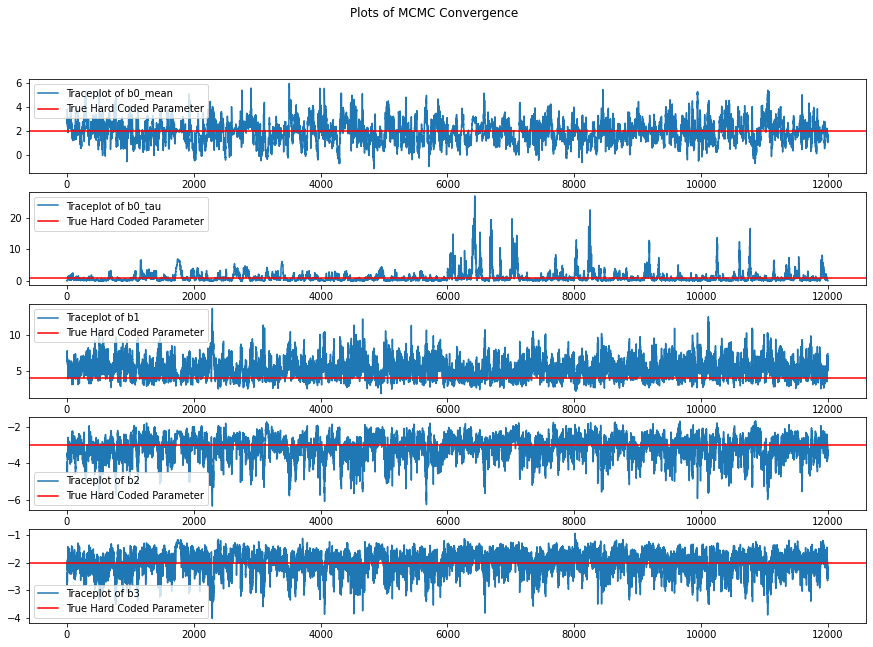

In [61]:
variables = {'b0_mean':2, 'b0_tau':1, 'b1':4, 'b2':-3, 'b3':-2}

fig, ax = plt.subplots(5, figsize = (15, 10))
plt.suptitle('Plots of MCMC Convergence')
for i, variable in enumerate(variables.keys()):
    ax[i].plot(trace[variable], label='Traceplot of ' + variable)
    ax[i].axhline(y=variables.get(variable), color='red', label='True Hard Coded Parameter')
    ax[i].legend()
plt.show(fig)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


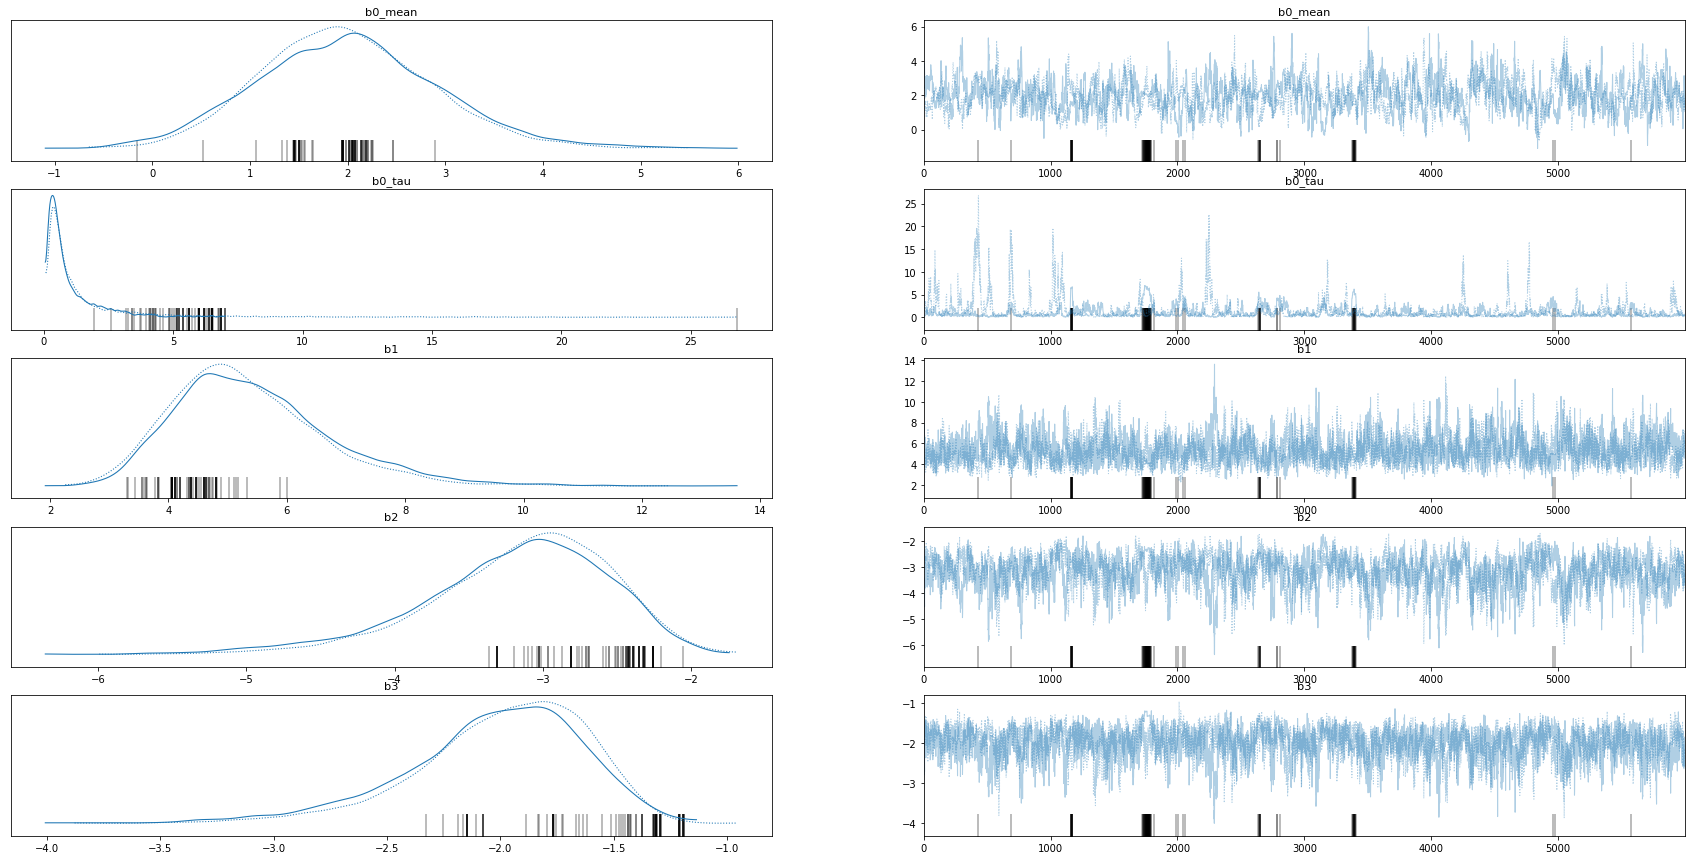

In [62]:

pm.traceplot(trace, var_names = ('b0_mean', 'b0_tau', 'b1', 'b2', 'b3'), figsize=(30, 15))
#plt.legend(fontsize = 40)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


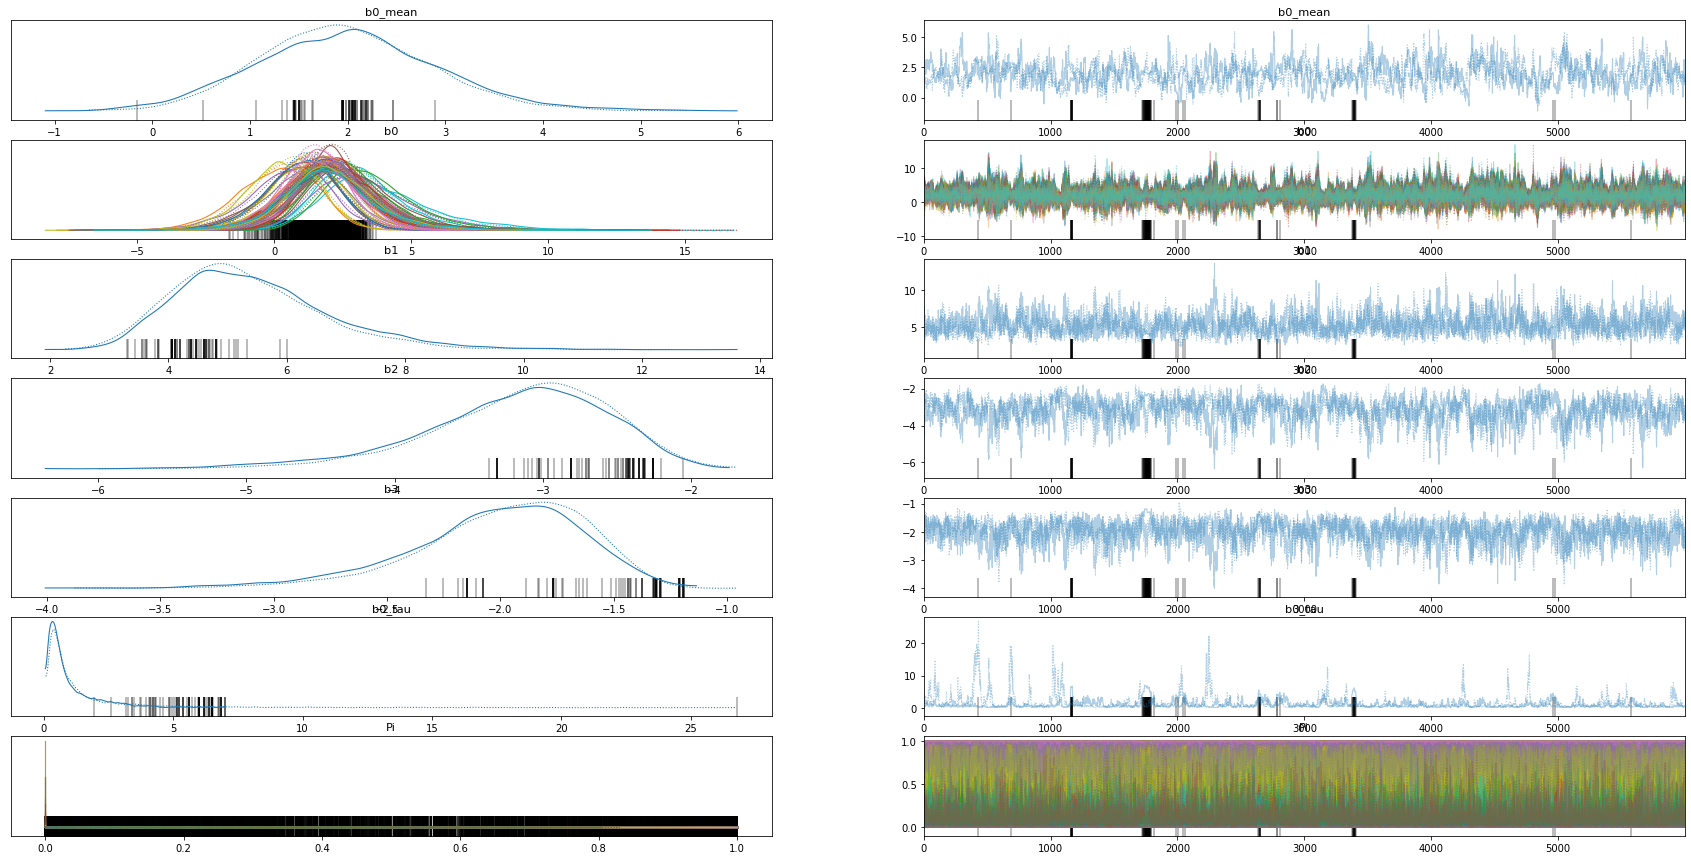

In [63]:
pm.traceplot(trace, figsize=(30, 15))
plt.show()

In [64]:
summary2 = pm.summary(trace)

variables = ['b0_mean', 'b0_tau', 'b1', 'b2', 'b3'] 
summary2.loc[variables, ]

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:949: RuntimeWarning: invalid value encountered in double_scalars
  fac_mcse_sd = np.sqrt(np.exp(1) * (1 - 1 / ess_sd_value) ** (ess_sd_value - 1) - 1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_mean,1.986,0.907,0.313,3.683,0.045,0.032,404.0,771.0,1.01
b0_tau,1.284,1.993,0.050,3.918,0.161,0.114,205.0,323.0,1.02
b1,5.375,1.295,3.225,7.905,0.059,0.042,469.0,1576.0,1.01
b2,-3.174,0.627,-4.394,-2.109,0.032,0.023,368.0,1038.0,1.01
b3,-2.008,0.383,-2.752,-1.366,0.018,0.013,409.0,767.0,1.01


**Interpretation:**

Each of the $\hat{R}$ values are similarly close to 1 and indicate the samplers have indeed converged. 

This is corroborated by the fact that the credible intervals are fairly equally spread on either side of the true values.

Furthermore, we can see from the table above that the mean value of the parameters, though not exaclty the same as the above-set hard coded values, is quite close to the true value of our hard coded parameters. This shows us that our posterior is indeed able to capture quite well the value of the parameters of our synthetic data. 

<div class='exercise-r'>

**2.5**  Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**



</div>

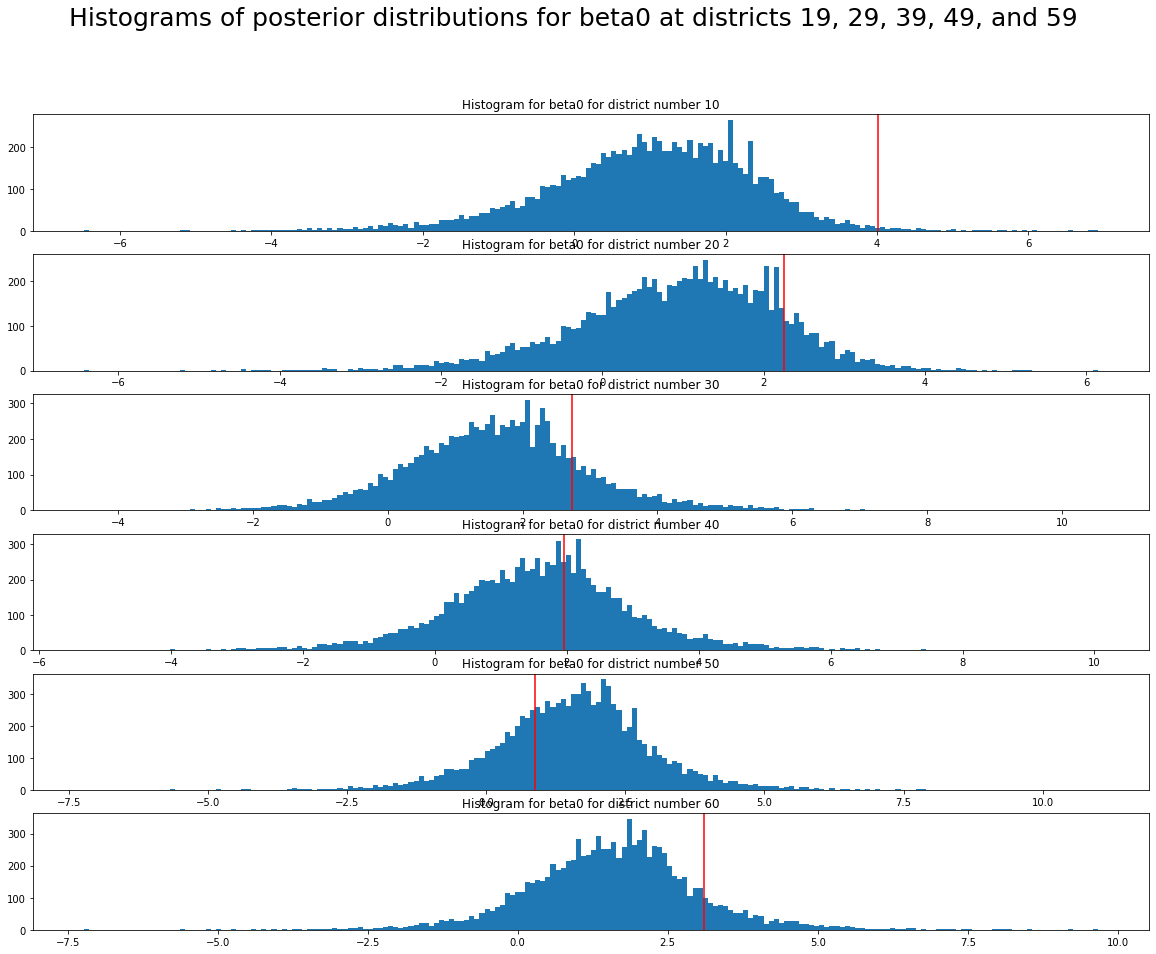

In [37]:

posteriors_to_plot = trace['b0'][:, [9, 19, 29, 39, 49, 59]]

fig, ax = plt.subplots(6,1 , figsize=(20, 15))
ax = ax.flatten()
plt.suptitle(f'Histograms of posterior distributions for beta0 at districts 19, 29, 39, 49, and 59', size = 25)


districts_to_plot = [9, 19, 29, 39, 49, 59]  

for index, to_plot in enumerate(ax):
    ax[index].hist(posteriors_to_plot[:, index], bins = 200)
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html
    ax[index].axvline(b0j[x_train['district']][index], color = 'red')
    ax[index].title.set_text(f'Histogram for beta0 for district number {districts_to_plot[index] +1}')


Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe956dea490>,
      dtype=object)

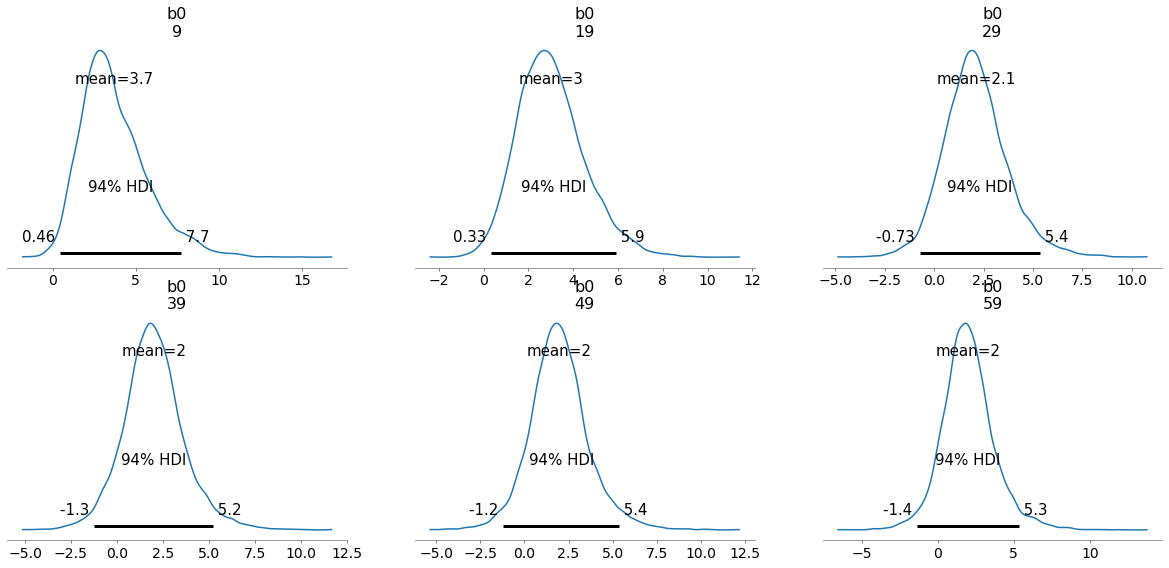

In [65]:
az.plot_posterior(trace, var_names = ['b0'], coords = {'b0_dim_0': [9, 19, 29, 39, 49, 59] })

#az.plot_posterior(posteriors_to_plot)

**Intepretation:**

The true parameters are contained within the each of our posterior distributions of our synthetic data, which gives us some reassurance that we should be able to use MCMC sampling to recover the true values of each of the parameters in the real training data.


Now that given this experiment worked out successfully, in 2.6 we can move on and apply the varying-intercept model to the real data and not the synthetic data and we can recover the true paramenters of the real data.

<div class='exercise-r'>

**2.6**  We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.



</div>

In [66]:

with pm.Model() as varying_intercept:

    mu_b0 = pm.Normal('b0_mean', mu=0, sigma=100)
    tau_b0 = pm.Gamma('b0_tau', alpha=0.1, beta=0.1)

    b0_j = pm.Normal('b0', mu = mu_b0, tau =  tau_b0, shape = 60 )

    b1 = pm.Normal('b1', mu = 0, sigma = 100)
    b2 = pm.Normal('b2',  mu = 0, sigma = 100)
    b3 = pm.Normal('b3',  mu = 0, sigma = 100)
    
    pi = pm.Deterministic('Pi', inv_logit(b0_j[x_train.district] 
    + b1* x_train['urban'] + b2*x_train['living.children'] + b3*x_train['age_mean']))


    y_synthetic = pm.Bernoulli('Contraceptives', p=pi, observed=y_train)
    
    trace_vi = pm.sample(6000, tune=15000, target_accept=0.9) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b3, b2, b1, b0, b0_tau, b0_mean]


Sampling 2 chains for 15_000 tune and 6_000 draw iterations (30_000 + 12_000 draws total) took 275 seconds.
The number of effective samples is smaller than 10% for some parameters.


<div class='exercise-r'>

**2.7**  Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?



</div>

In [67]:
summary2_6 = pm.summary(trace_vi)


Got error No model on context stack. trying to find log_likelihood in translation.


In [68]:
variables = ['b0_mean', 'b0_tau', 'b1', 'b2', 'b3']
summary2_6.loc[variables, ]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_mean,-1.594,0.255,-2.098,-1.145,0.008,0.006,919.0,1833.0,1.0
b0_tau,3.836,1.687,1.420,6.924,0.036,0.027,2431.0,3480.0,1.0
b1,0.737,0.163,0.430,1.038,0.002,0.002,5064.0,7992.0,1.0
b2,0.320,0.082,0.172,0.480,0.003,0.002,1000.0,1975.0,1.0
b3,-0.034,0.011,-0.056,-0.013,0.000,0.000,1697.0,3762.0,1.0


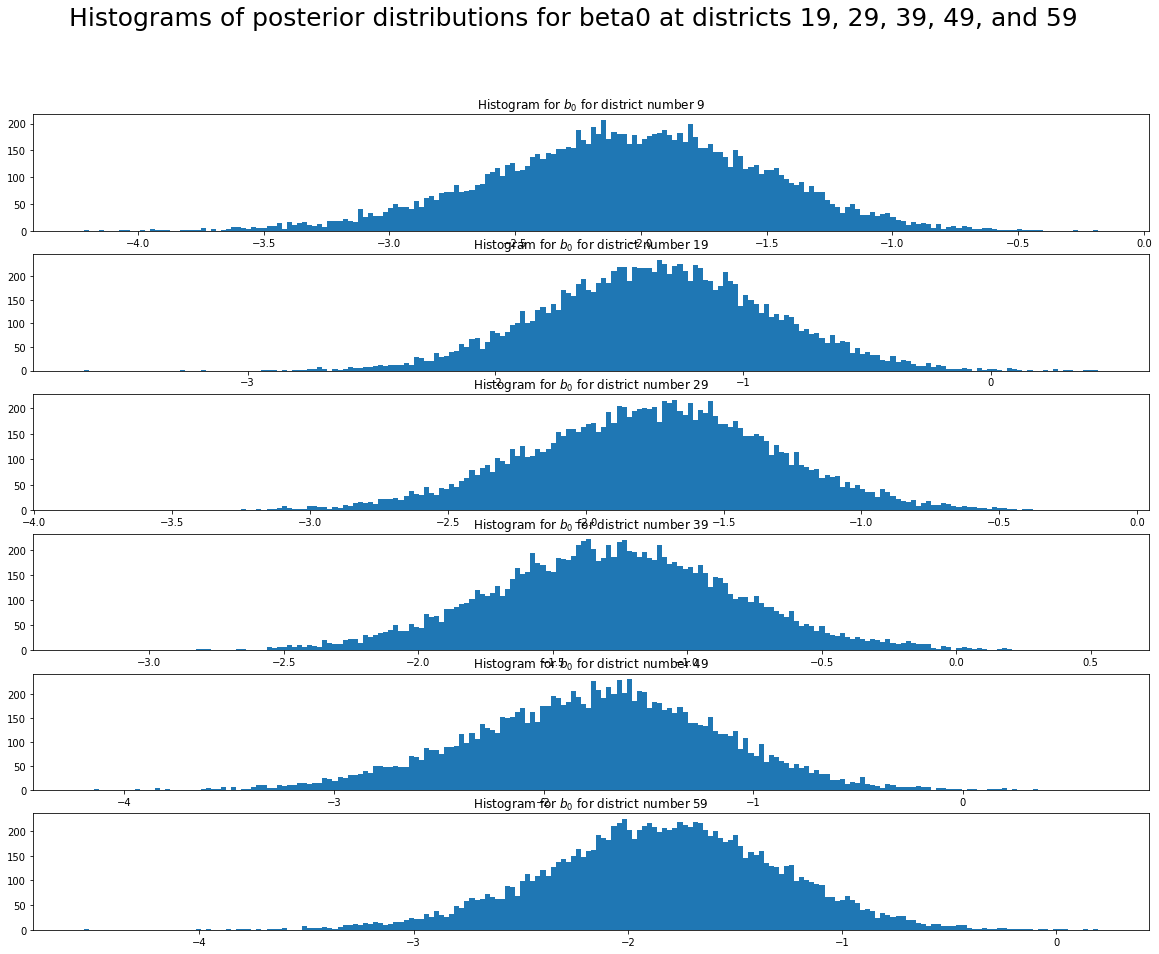

In [69]:

posteriors_to_plot = trace_vi['b0'][:, [9, 19, 29, 39, 49, 59]]

fig, ax = plt.subplots(6,1 , figsize=(20, 15))
ax = ax.flatten()
plt.suptitle(f'Histograms of posterior distributions for beta0 at districts 19, 29, 39, 49, and 59', size = 25)


districts_to_plot = [9, 19, 29, 39, 49, 59]
for index, to_plot in enumerate(ax):
    ax[index].hist(posteriors_to_plot[:, index], bins = 200)
    ax[index].title.set_text(f'Histogram for $b_0$ for district number {districts_to_plot[index]}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


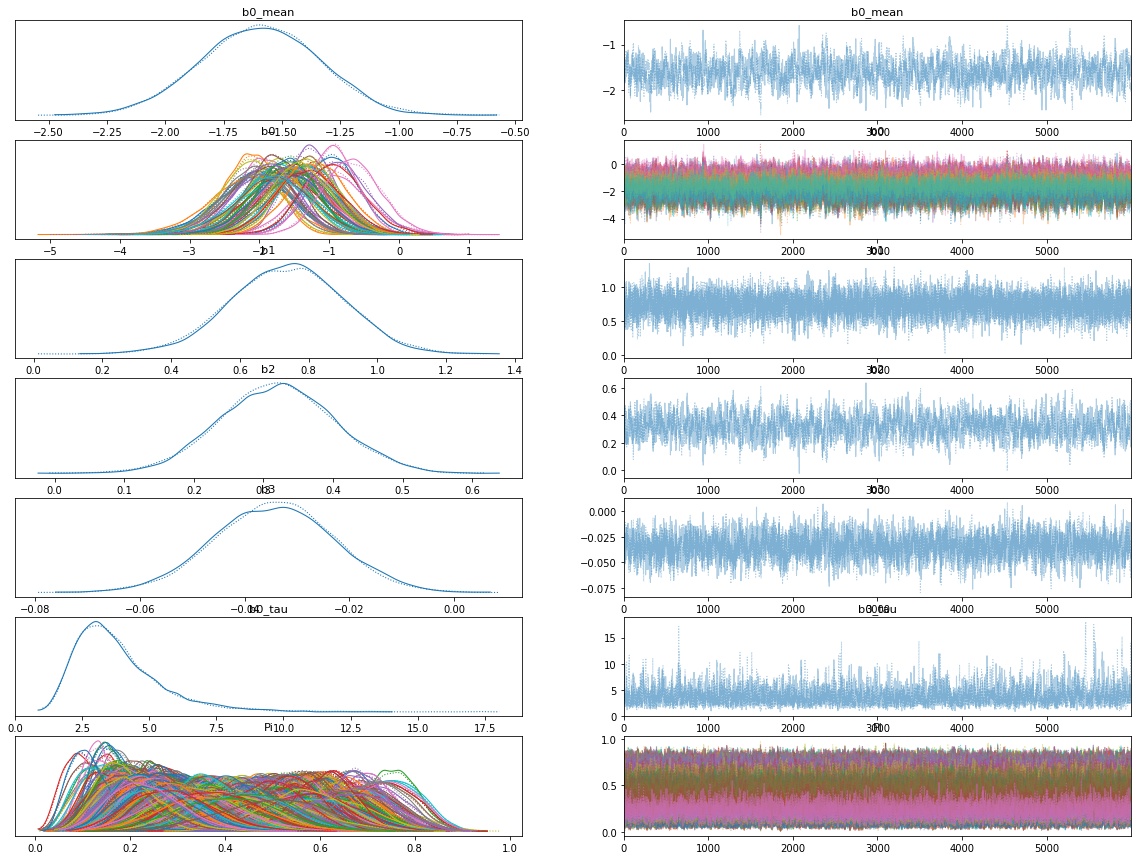

In [70]:
pm.traceplot(trace_vi, figsize=(20, 15))
plt.show()


**Interpretation:**

The posterior distributions are overlapping and mixed, showing that the sampler has converged. 

Again, with $\hat{R}$ values similarly close to 1 we have more indication that the samplers converged. 

Also, the credible intervals are very narrow, showing that we have little uncertainty in the range of the parameters.

<div class='exercise-r'>

**2.8**  Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?



</div>

In [71]:
mean_of_districts = summary2_6['mean'][1:61]  
mean_of_districts = mean_of_districts.tolist()

highest_mean_value = max(mean_of_districts)
highest_district = mean_of_districts.index(highest_mean_value)

lowest_mean_value = min(mean_of_districts)
lowest_district = mean_of_districts.index(lowest_mean_value)

print(f'The district with highest usage of contraceptives is {highest_district} with an average usage of {highest_mean_value}')
print(f'The district with lowest usage of contraceptives is {lowest_district} with an average usage of {lowest_mean_value}')

The district with highest usage of contraceptives is 56 with an average usage of -0.677
The district with lowest usage of contraceptives is 11 with an average usage of -2.194


**Intepretation:**

Above we use the posterior means to calculate that the district with the highest rate of contraceptive usage is district 57. The district with the lowest rate is district 12.

<div class='exercise-r'>

**2.9**  What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

</div>

In [72]:
mu_mean_ = summary2_6.loc['b0_mean']['mean']
tau_mean_ = summary2_6.loc['b0_tau']['mean'] #this is tau

sigma = np.sqrt(1/tau_mean_)

In [73]:
print(f'The posterior mean of mu_0 is {mu_mean_}')

print(f'The posterior mean of sigma_0 is {sigma}')


The posterior mean of mu_0 is -1.594
The posterior mean of sigma_0 is 0.5105763575534971


**Interpretation:**

The posterior mean of $\mu_0$ is -1.6 and the posterior mean of $\sigma_0$ is 0.5. 

Varying intercepts models have intercepts which are drawn from a normal distribution with these two parameters. Since drawing from this distribution would give values spread around a mean of -1.604, this would certainly change the model. We can take this as evidence in support of a varying-intercept model.

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 3: Varying-Coefficients Model and Model Selection

[Return to contents](#contents)


<a id="part3intro"></a>

## Overview 

[Return to contents](#contents)

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on `living.children`, `age_mean`, and `urban` vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:** Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<a id="part3questions"></a>

### <div class='exercise'>Part 3: Questions</div> 

[Return to contents](#contents)

**3.1** Fit the varying-coefficients model described above to the real training data.

**3.2** Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?

**3.3** Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

**3.4** Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

<a id="part3solutions"></a>

## Part 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit the varying-coefficients model described above to the real training data.



</div>

In [74]:


with pm.Model() as varying_coefficients:

    mu_b0 = pm.Normal('prior_b0_mean', mu=0, sigma=100)
    tau_b0 = pm.Gamma('b0_tau', alpha=0.1, beta=0.1)
    b0_j = pm.Normal('b0', mu = mu_b0, tau =  tau_b0, shape = 60 )
    b0_j = b0_j[x_train.district] 


    tau_b1 = pm.Gamma('prior_b1_tau', alpha=0.1, beta=0.1)
    b1_j = pm.Normal('b1', mu = 0, tau =  tau_b1, shape = 60 )
    b1_j = b1_j[x_train.district] 


    tau_b2 = pm.Gamma('prior_b2_tau', alpha=0.1, beta=0.1)
    b2_j = pm.Normal('b2', mu = 0, tau =  tau_b2, shape = 60 )
    b2_j = b2_j[x_train.district] 


    tau_b3 = pm.Gamma('prior_b3_tau', alpha=0.1, beta=0.1)
    b3_j = pm.Normal('b3', mu = 0, tau =  tau_b3, shape = 60 )
    b3_j = b3_j[x_train.district] 
    
    pi = pm.Deterministic('Pi', inv_logit(b0_j 
    + b1_j* x_train['urban'] + b2_j*x_train['living.children'] + b3_j*x_train['age_mean']))


    y_synthetic = pm.Bernoulli('Contraceptives', p=pi, observed=y_train)
    
    trace_3 = pm.sample(6000, tune=15000, target_accept=0.9) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b3, prior_b3_tau, b2, prior_b2_tau, b1, prior_b1_tau, b0, b0_tau, prior_b0_mean]


Sampling 2 chains for 15_000 tune and 6_000 draw iterations (30_000 + 12_000 draws total) took 499 seconds.
The number of effective samples is smaller than 10% for some parameters.


<div class='exercise-r'>

**3.2**  Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?



</div>

In [75]:
summary3 = pm.summary(trace_3)

Got error No model on context stack. trying to find log_likelihood in translation.


In [76]:
summary3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_b0_mean,-0.793,0.145,-1.070,-0.531,0.003,0.002,2406.0,5519.0,1.0
b0[0],-1.043,0.447,-1.902,-0.213,0.006,0.005,5516.0,6156.0,1.0
b0[1],-0.944,0.395,-1.702,-0.212,0.005,0.004,6402.0,6204.0,1.0
b0[2],-0.874,0.428,-1.681,-0.028,0.004,0.003,10300.0,7454.0,1.0
b0[3],-0.693,0.484,-1.580,0.265,0.005,0.004,9045.0,6744.0,1.0
...,...,...,...,...,...,...,...,...,...
Pi[962],0.298,0.160,0.048,0.604,0.002,0.001,11059.0,9141.0,1.0
Pi[963],0.250,0.144,0.020,0.513,0.001,0.001,12504.0,8001.0,1.0
Pi[964],0.206,0.085,0.062,0.367,0.001,0.001,8261.0,7697.0,1.0
Pi[965],0.319,0.181,0.041,0.662,0.002,0.001,9922.0,8423.0,1.0


In [77]:
summary3['r_hat'].value_counts()


1.0    1212
Name: r_hat, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


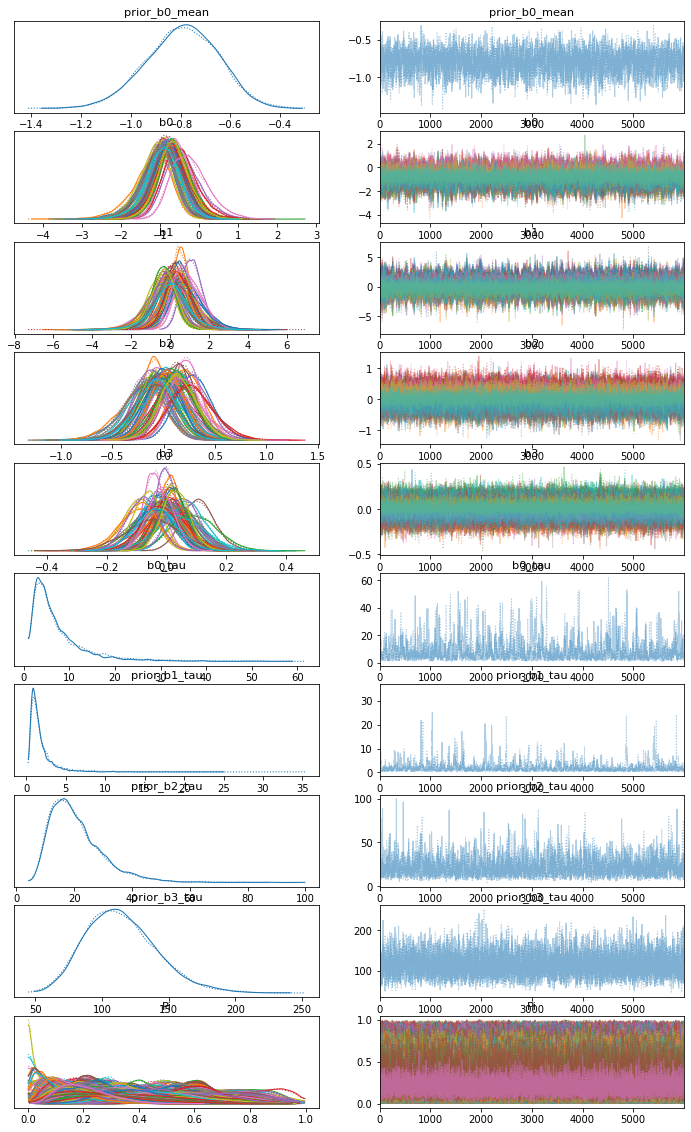

In [78]:
pm.traceplot(trace_3)
plt.show()


**Interpretation:**

With each of the $\hat{R}$ values similarly close to 1, we have an indication that our varying intercept model does converge. The trace plots also show corroborate that finding, as they do not show correlated peaks.

<div class='exercise-r'>

**3.3**  Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.



</div>

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


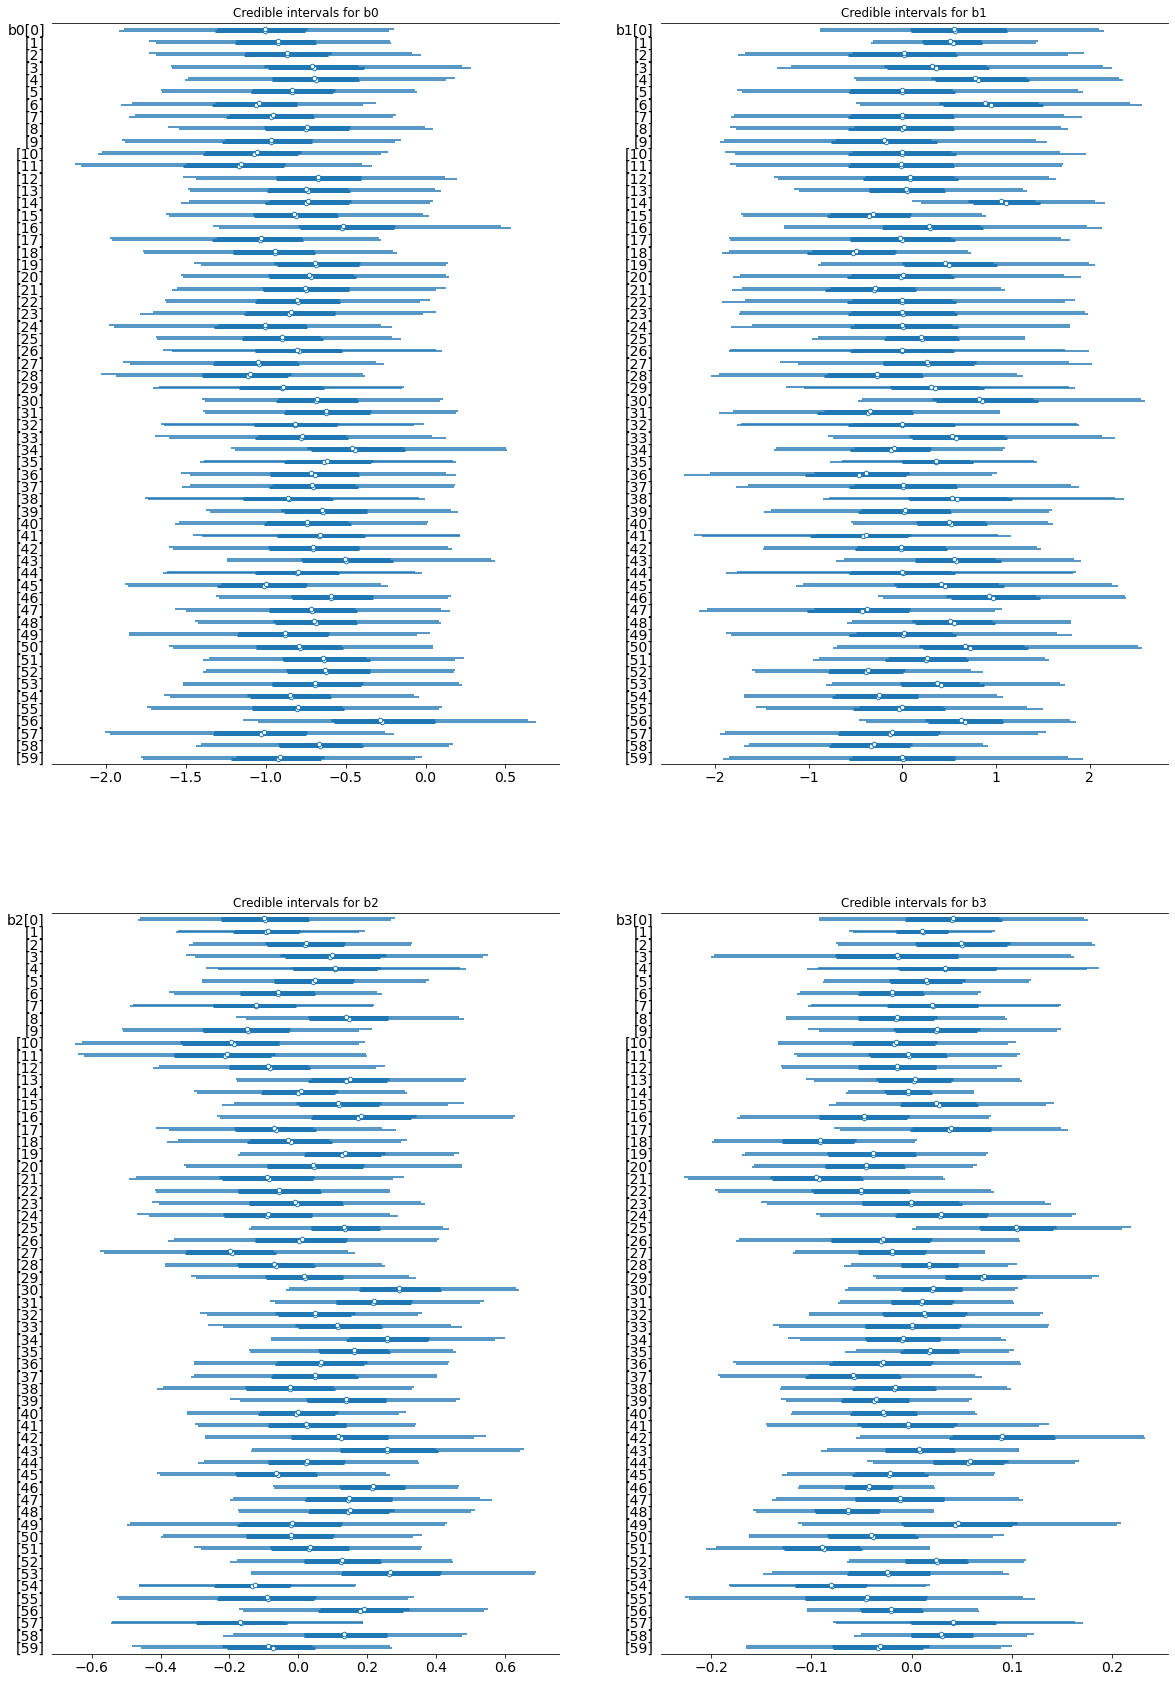

In [79]:


variables = ['b0', 'b1', 'b2', 'b3']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,30))
ax = ax.ravel()
for index, value in enumerate(variables):
    az.plot_forest(data=trace_3, var_names=[value], ax = ax[index])
    ax[index].set_title(f'Credible intervals for {value}')

**Interpretation:**

These four plots correspond to the credible intervals for each district for the model intercepts as well as coefficients of the urban, children, and age features. 


These credible intervals are centered around different means, but still overlap quite a bit. We know from previous analysis in part 2 that a varying-intercepts model has merit here, and these differing-yet-overlapping credible intervals do not refute that judgement.


The width of the bars indicates the level of uncertainty present in the analysis, which appears to be fairly narrow (low uncertainty). Across districts, we see that the value of these credible intervals are varying, which shows the need of an ad-hoc parameter per districts --> hence the varying coefficients model.



<div class='exercise-r'>

**3.4**  Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

</div>

In [327]:
naive_evaluation_train = (y_train ==0).mean()
naive_evaluation_test = (y_test ==0).mean()

print(f'The naive model considering that no woman uses contraceptives has {naive_evaluation_train} training accuracy ')
print(f'The naive model considering that no woman uses contraceptives has {naive_evaluation_test} testing accuracy ')


print(f'The naive model considering that no woman uses contraceptives has {1-naive_evaluation_train} training classification percentage ')
print(f'The naive model considering that no woman uses contraceptives has {1-naive_evaluation_test} testing classification percentage ')

The naive model considering that no woman uses contraceptives has 0.610134436401241 training accuracy 
The naive model considering that no woman uses contraceptives has 0.6049638055842813 testing accuracy 
The naive model considering that no woman uses contraceptives has 0.389865563598759 training classification percentage 
The naive model considering that no woman uses contraceptives has 0.3950361944157187 testing classification percentage 


In [330]:
b0_3 = summary3.iloc[1:61]
b1_3 = summary3.iloc[61:121]
b2_3 = summary3.iloc[121:181]
b3_3 = summary3.iloc[181:241]
# b3_3.iloc[1]


In [331]:
b0_2 = summary2_6.iloc[1:61]
b1_2 = summary2_6.iloc[61]
b2_2 = summary2_6.iloc[62]
b3_2 = summary2_6.iloc[63]
# b3_2['mean']

In [360]:
def flatten_list(unflat_list):
    flat_list = []
    indexes_list = []


    # Iterate through the outer list
    for element in unflat_list:

        if type(element) is pd.Series:
          # print('true')
          # If the element is of type list, iterate through the sublist
          for index, item in element.items():
              flat_list.append(item)
              indexes_list.append(index)

      # else:
      #     flat_list.append(element)
    return flat_list

**Varying Coefficients Model**

In [362]:
#### VARYING COEFFICIENTS

list_pi_vc= []
for i in range(60):
  x_train_district_i = x_train.loc[x_train['district']==i]
  y_train_district_i = df_train.loc[df_train['district']==i]['contraceptive_use']
  pi_vc = inv_logit(b0_3.iloc[i]['mean'] 
                 + b1_3.iloc[i]['mean']* x_train_district_i['urban'] 
                 + b2_3.iloc[i]['mean']* x_train_district_i['living.children'] 
                 + b3_3.iloc[i]['mean']* x_train_district_i['age_mean'])
  list_pi_vc.append(pi_vc)
  
list_pi_vc_flattened = flatten_list(list_pi_vc)
y_pred_train = [1 if i >= 0.5 else 0 for i in list_pi_vc_flattened]
accuracy_train = (y_pred_train == y_train).mean()
classification_rate_train = np.mean(y_pred_train)
print(f'The varying coefficients model has an training accuracy of: {accuracy_train}')
print(f'The varying coefficients model has an training classification of: {classification_rate_train}')
print()
print()


list_pi_vc_test= []
for i in range(60):
  x_test_district_i = x_test.loc[x_test['district']==i]
  y_test_district_i = df_test.loc[df_test['district']==i]['contraceptive_use']
  pi_vc_test = inv_logit(b0_3.iloc[i]['mean'] 
                 + b1_3.iloc[i]['mean']* x_test_district_i['urban'] 
                 + b2_3.iloc[i]['mean']* x_test_district_i['living.children'] 
                 + b3_3.iloc[i]['mean']* x_test_district_i['age_mean'])
  list_pi_vc_test.append(pi_vc_test)
  
list_pi_vc_flattened = flatten_list(list_pi_vc_test)
y_pred_test = [1 if i >= 0.5 else 0 for i in list_pi_vc_flattened]
accuracy_test = (y_pred_test == y_test).mean()
classification_rate_test = np.mean(y_pred_test)
print(f'The varying coefficients model has an testing accuracy of: {accuracy_test}')
print(f'The varying coefficients model has an testing classification of: {classification_rate_test}')

The varying coefficients model has an training accuracy of: 0.5667011375387797
The varying coefficients model has an training classification of: 0.27094105480868663


The varying coefficients model has an testing accuracy of: 0.5801447776628749
The varying coefficients model has an testing classification of: 0.2647362978283351


**Varying Intercepts Model**

In [338]:
#### VARYING INTERCEPTS

list_pi_vc= []
for i in range(60):
  x_train_district_i = x_train.loc[x_train['district']==i]
  y_train_district_i = df_train.loc[df_train['district']==i]['contraceptive_use']
  pi_vc = inv_logit(b0_2.iloc[i]['mean'] 
                 + b1_2['mean']* x_train_district_i['urban'] 
                 + b2_2['mean']* x_train_district_i['living.children'] 
                 + b3_2['mean']* x_train_district_i['age_mean'])
  list_pi_vc.append(pi_vc)
  
list_pi_vc_flattened = flatten_list(list_pi_vc)
y_pred_train = [1 if i >= 0.5 else 0 for i in list_pi_vc_flattened]
accuracy_train = (y_pred_train == y_train).mean()
classification_rate_train = np.mean(y_pred_train)
print(f'The varying intercepts model has an training accuracy of: {accuracy_train}')
print(f'The varying intercepts model has an training classification of: {classification_rate_train}')
print()
print()


list_pi_vc_test= []
for i in range(60):
  x_test_district_i = x_test.loc[x_test['district']==i]
  y_test_district_i = df_test.loc[df_test['district']==i]['contraceptive_use']
  pi_vc_test = inv_logit(b0_2.iloc[i]['mean'] 
                 + b1_2['mean']* x_test_district_i['urban'] 
                 + b2_2['mean']* x_test_district_i['living.children'] 
                 + b3_2['mean']* x_test_district_i['age_mean'])
  list_pi_vc_test.append(pi_vc_test)
  
list_pi_vc_flattened = flatten_list(list_pi_vc_test)
y_pred_test = [1 if i >= 0.5 else 0 for i in list_pi_vc_flattened]
accuracy_test = (y_pred_test == y_test).mean()
classification_rate_test = np.mean(y_pred_test)
print(f'The varying intercepts model has an testing accuracy of: {accuracy_test}')
print(f'The varying intercepts model has an testing classification of: {classification_rate_test}')

The varying intercepts model has an training accuracy of: 0.5532574974146846
The varying intercepts model has an training classification of: 0.22440537745604963


The varying intercepts model has an testing accuracy of: 0.5987590486039297
The varying intercepts model has an testing classification of: 0.20889348500517063


**Interpretation:**

My results seem to be very off. I have had trouble with figuring out how to index these properly and I get an outcome where the naive model is the best one. This is clearly incorrect and there are bugs on the code to fix, because the varying intercept model and the varying coefficients model should definitely outperform the naive model. Additionally, I would expect the varying coefficient model to do better than the varyin intercept model, because we are having ad-hoc parameters for each district instead of having only an ad-hoc intercept.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a93769f-728f-45c8-abdc-b8dee7bd3547' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>